In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
qaoa_results_path = "qaoa_dataset_parallel.npy"
qaoa_results = np.load(qaoa_results_path,allow_pickle=True).item()

qrl_results_path = "logs/rodrigo/final_qrl_results.npy"
qrl_results = np.load(qrl_results_path,allow_pickle=True).item()

qrl_results_path = "logs/rodrigo/hwe_results.npy"
qrl_results__hwe = np.load(qrl_results_path,allow_pickle=True).item()

In [11]:
qrl_results

{'approximation_ratios': {'3': {'PG': {'test': array([0.03858156, 1.        , 0.92112676, 1.        , 0.87842839,
           0.96855346, 1.        , 1.        , 0.75525773, 1.        ,
           1.        , 1.        , 1.        , 0.62412698, 1.        ,
           0.98426667, 1.        , 1.        , 0.57333333, 0.94680851,
           1.        , 1.        , 0.83045872, 0.96204082, 0.92171717,
           0.84246914, 1.        , 1.        , 0.99479416, 0.87681159,
           0.9620202 , 1.        , 1.        , 0.94038159, 0.979442  ,
           1.        , 0.87533333, 0.98299694, 0.86285714, 0.90666667,
           0.39666667, 1.        , 0.9975873 , 0.98559006, 0.96015326,
           0.92488263, 0.96      , 0.90736842, 1.        , 0.98187702,
           0.96614853, 0.69010526, 1.        , 1.        , 1.        ,
           0.75243665, 0.33333333, 1.        , 1.        , 0.99503268,
           0.95365967, 0.92035398, 1.        , 1.        , 0.72571429,
           0.99412756, 1.        ,

In [4]:
types = ["slack","unbalanced"]
problem_sizes = [4,5,6,7,8,9,10]
dataset_size = 100

qaoa_final_results = {}

for type_ in types:
    qaoa_final_results[type_] = {}
    for problem_size in problem_sizes:
        qaoa_final_results[type_][problem_size] = {}
        for i in range(dataset_size):
            qaoa_final_results[type_][problem_size][f'{i}'] = {}
            qaoa_final_results[type_][problem_size][f'{i}']["optimal_probability"] = qaoa_results[type_][problem_size][f'{i}']["probability"]


In [5]:
dataset = np.load("/home/users/kruse/quantum-computing/QRL/games/knapsack/KP_dataset.npy",allow_pickle=True).item()
# dataset["3"]["validation"]["0"]

for i, problem_size in enumerate(problem_sizes):
    aux_dataset = dataset[f"{problem_size}"]["validation"]

    values = []
    weights = []
    maximum_weight = []

    for j in range(100):
        values.append(aux_dataset[f"{j}"]["values"])
        weights.append(aux_dataset[f"{j}"]["weights"])
        maximum_weight.append(aux_dataset[f"{j}"]["maximum_weight"])

    items = len(values[0])
    actions = np.reshape(np.unpackbits(np.arange(2**items).astype('>i8').view(np.uint8)), (-1, 64))[:,-items:]
    random_probability = 1/(2**items)

    for j in range(100):
        probabilities_slack = qaoa_results["slack"][problem_size][f"{j}"]["probabilities"]
        probabilities_unbalanced = qaoa_results["unbalanced"][problem_size][f"{j}"]["probabilities"]

        probability_valid_slack = 0
        probability_valid_unbalanced = 0
        average_random_contribution = 0
        slack_contribution = 0
        unbalanced_contribution = 0

        for k, action in enumerate(actions):
            weight = sum(action[z]*weights[j][z] for z in range(items))
            if round(weight,2) <= maximum_weight[j]:
                contribution = sum(action[z]*values[j][z] for z in range(items))
                probability_valid_slack += probabilities_slack[k]
                probability_valid_unbalanced += probabilities_unbalanced[k]
                average_random_contribution += contribution * random_probability
                slack_contribution += probabilities_slack[k] * contribution
                unbalanced_contribution += probabilities_unbalanced[k] * contribution
        
        qaoa_final_results["slack"][problem_size][f'{j}']["valid_probability"] = probability_valid_slack
        qaoa_final_results["unbalanced"][problem_size][f'{j}']["valid_probability"] = probability_valid_unbalanced

        qaoa_final_results["slack"][problem_size][f'{j}']["better_than_random"] = slack_contribution/average_random_contribution
        qaoa_final_results["unbalanced"][problem_size][f'{j}']["better_than_random"] = unbalanced_contribution/average_random_contribution

In [6]:
qaoa_results_final = {}
for type_ in types:
    qaoa_results_final[type_] = {}
    for problem in problem_sizes:
        qaoa_results_final[type_][problem] = {}
        qaoa_results_final[type_][problem]["optimal_probability"] = []
        qaoa_results_final[type_][problem]["valid_probability"] = []
        qaoa_results_final[type_][problem]["better_than_random"] = []
        for i in range(dataset_size):
            qaoa_results_final[type_][problem]["optimal_probability"].append(qaoa_final_results[type_][problem][f'{i}']["optimal_probability"])
            qaoa_results_final[type_][problem]["valid_probability"].append(qaoa_final_results[type_][problem][f'{i}']["valid_probability"])
            qaoa_results_final[type_][problem]["better_than_random"].append(qaoa_final_results[type_][problem][f'{i}']["better_than_random"])


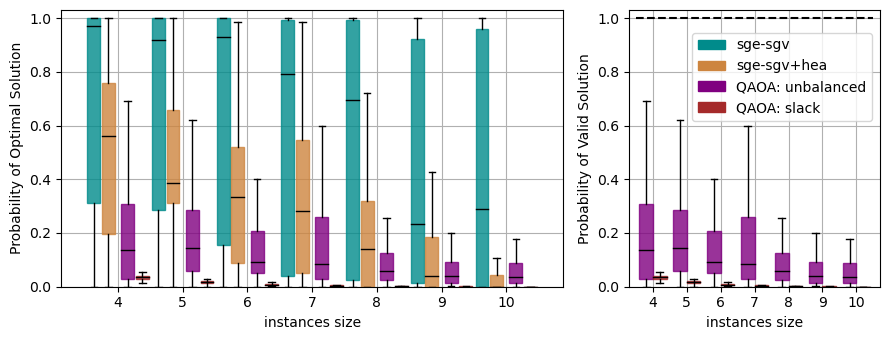

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, (ax, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(9, 3.5), width_ratios=[2, 1])
colors = ['darkcyan', 'peru', 'purple', 'brown']
# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code
for i, size in enumerate(problem_sizes):
    positions = [size - 0.375, size - 0.15, size + 0.15, size + 0.375]
    labels = ["s-ppgl", "angular", "QAOA: unbalanced", "QAOA: slack"]
    # labels = [range(4, 11)]
    data = [
        qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"],
        # qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"],
        # qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"],
        qrl_results__hwe["optimal_probability"][f"{size}"]["PG"]["validation"],
        qaoa_results_final["unbalanced"][size]["optimal_probability"],
        qaoa_results_final["slack"][size]["optimal_probability"]
    ]
    bp = ax.boxplot(data, positions=positions, patch_artist=True, showfliers=False, widths=0.2, medianprops=dict(color='black'))

    # Set custom colors for each boxplot
    for j, box in enumerate(bp['boxes']):
        box.set_color(colors[j])
        box.set_alpha(0.8)
        # box.median.set(color='black')

# Set custom x-axis ticks
ax.set_xticks(range(4, 11))
ax.set_xticklabels(range(4, 11))
ax.grid('yaxis')
ax.set_ylim(0, 1.03)
# ax.legend(labels)
ax.set_xlabel("instances size")
ax.set_ylabel("Probability of Optimal Solution")


colors2 = ['purple', 'brown']
# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code
for i, size in enumerate(problem_sizes):
    positions = [size - 0.2, size + 0.2]
    labels = ["sge-sgv", "sge-sgv+hea", "QAOA: unbalanced", "QAOA: slack"]
    # labels = [range(4, 11)]
    data = [
        # qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"],
        # qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"],
        # qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"],
        # qrl_results["optimal_probability"][f"{size}"]["=angular"]["validation"],
        qaoa_results_final["unbalanced"][size]["optimal_probability"],
        qaoa_results_final["slack"][size]["optimal_probability"]
    ]
    bp = ax2.boxplot(data, positions=positions, patch_artist=True, showfliers=False, widths=0.4, medianprops=dict(color='black'))

    # Set custom colors for each boxplot
    for j, box in enumerate(bp['boxes']):
        box.set_color(colors2[j])
        box.set_alpha(0.8)
        # box.median.set(color='black')

# Set custom x-axis ticks
ax2.set_xticks(range(4, 11))
ax2.set_xticklabels(range(4, 11))
ax2.grid('yaxis')
# ax2.legend(labels)
patches = []
for i in range(4):
    patches.append(mpatches.Rectangle((0,0), 1, 0.01, color=colors[i]))
ax2.legend(patches, labels, loc=[0.25, 0.6])
# for idx, leg in enumerate(ax2.get_legend().legendHandles):
#     leg.set_color(colors[idx])
#     leg.

ax2.set_ylim(0, 1.03)
ax2.hlines(1.0, 3.5, 10.5, colors='black', linestyles='dashed')
ax2.set_xlabel("instances size")
ax2.set_ylabel("Probability of Valid Solution")
# fig.title("Boxplot of Optimal Solution Probability for Different Problem Sizes")

# Display the plot
plt.savefig("qrlvsqaoa2.pdf")
plt.show()



TypeError: boxplot() got an unexpected keyword argument 'label'

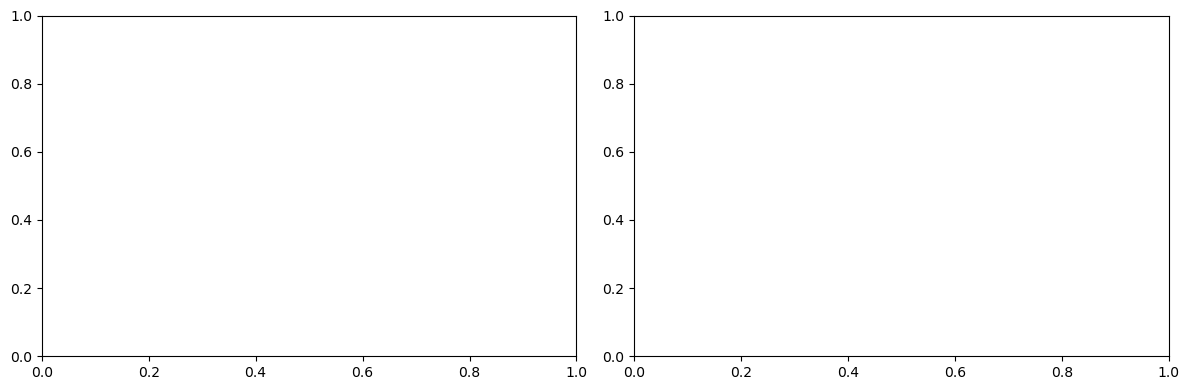

In [11]:
import matplotlib.pyplot as plt

# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code

fig, ax = plt.subplots(1,2,tight_layout = True, figsize = (12,4))

# # Plot the data as a vertical scatter plot
# for i,size in enumerate(problem_sizes):
#     ax[0].scatter([size - 0.25] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["test"], marker = "x",color='green', alpha=0.3, label="s-ppgl: training" if i == 0 else None)
#     ax[0].scatter([size - 0.1] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="s-ppgl: validation" if i == 0 else None)
#     ax[0].scatter([size + 0.1] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=angular"]["test"], marker = "x",color='blue', alpha=0.3, label="angular: training" if i == 0 else None)
#     ax[0].scatter([size + 0.25] * dataset_size, qrl_results["approximation_ratios"][f"{size}"]["=angular"]["validation"], marker = "x",color='red', alpha=0.3, label="angular: validation" if i == 0 else None)

# # Set custom x-axis ticks
# custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
# ax[0].set_xticks(custom_ticks)

# ax[0].set_xlabel("Instances Size")
# ax[0].set_ylabel("Approximation Ratio")
# # Manually create legend
# ax[0].legend(["s-ppgl: training", "s-ppgl: validation","angular: training","angular: validation"])

for i,size in enumerate(problem_sizes):
    ax[0].boxplot([size - 0.4] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"],label="s-ppgl" if i == 0 else None)
    ax[0].boxplot([size - 0.25] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"], label="h-ppgl" if i == 0 else None)
    ax[0].boxplot([size - 0.1] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"], label="m-ppgl" if i == 0 else None)
    ax[0].boxplot([size + 0.1] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=angular"]["validation"],label="angular" if i == 0 else None)
    ax[0].boxplot([size + 0.25] * dataset_size, qaoa_results_final["unbalanced"][size]["optimal_probability"],  label="QAOA: unbalanced" if i == 0 else None)
    ax[0].boxplot([size + 0.4] * dataset_size, qaoa_results_final["slack"][size]["optimal_probability"],  label="QAOA: slack" if i == 0 else None)

# for i,size in enumerate(problem_sizes):
#     ax[0].scatter([size - 0.4] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"], marker = "o",color='darkcyan', alpha=0.3, label="s-ppgl" if i == 0 else None)
#     ax[0].scatter([size - 0.25] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"], marker = "o",color='slategray', alpha=0.3, label="h-ppgl" if i == 0 else None)
#     ax[0].scatter([size - 0.1] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"], marker = "o",color='indianred', alpha=0.3, label="m-ppgl" if i == 0 else None)
#     ax[0].scatter([size + 0.1] * dataset_size, qrl_results["optimal_probability"][f"{size}"]["=angular"]["validation"], marker = "o",color='peru', alpha=0.3, label="angular" if i == 0 else None)
#     ax[0].scatter([size + 0.25] * dataset_size, qaoa_results_final["unbalanced"][size]["optimal_probability"], marker = "o",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)
#     ax[0].scatter([size + 0.4] * dataset_size, qaoa_results_final["slack"][size]["optimal_probability"], marker = "o",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)


# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0].set_xticks(custom_ticks)
ax[0].grid('both')
ax[0].set_xlabel("Instances Size")
ax[0].set_ylabel("Probability of Optimal Solution")
ax[0].set_yscale("log")

# Manually create legend
l0 = ax[0].legend(["sge-sgv", "mge-sgv","mge-mgv","angular", "QAOA: slack", "QAOA: unbalanced"], loc='lower left')

for item in l0.legendHandles:
    item._alpha = 1.0 #("black")

for i,size in enumerate(problem_sizes):
    ax[1].scatter([size - 0.4] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=s-ppgl"]["validation"], marker = "o",color='darkcyan', alpha=0.3, label="s-ppgl" if i == 0 else None)
    ax[1].scatter([size - 0.25] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=h-ppgl"]["validation"], marker = "o",color='slategray', alpha=0.3, label="h-ppgl" if i == 0 else None)
    ax[1].scatter([size - 0.1] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=m-ppgl"]["validation"], marker = "o",color='indianred', alpha=0.3, label="m-ppgl" if i == 0 else None)
    ax[1].scatter([size + 0.1] * dataset_size, qrl_results["valid_probability"][f"{size}"]["=angular"]["validation"], marker = "o",color='peru', alpha=0.3, label="angular" if i == 0 else None)
    ax[1].scatter([size + 0.25] * dataset_size, qaoa_results_final["unbalanced"][size]["valid_probability"], marker = "o",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)
    ax[1].scatter([size + 0.4] * dataset_size, qaoa_results_final["slack"][size]["valid_probability"], marker = "o",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1].set_xticks(custom_ticks)
ax[1].grid('both')
ax[1].set_xlabel("Instances Size")
ax[1].set_ylabel("Probability of Valid Solution")

# Manually create legend
l1 = ax[1].legend(["sge-sgv", "mge-sgv","mge-mgv","angular", "QAOA: slack", "QAOA: unbalanced"], loc='lower left')



for item in l1.legendHandles:
    item._alpha = 1.0 #("black")
# for i,size in enumerate(problem_sizes):
#     ax[1,1].scatter([size - 0.3] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=s-ppgl"]["validation"], marker = "x",color='green', alpha=0.3, label="s-ppgl" if i == 0 else None)
#     ax[1,1].scatter([size - 0.2] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=m-ppgl"]["validation"], marker = "x",color='orange', alpha=0.3, label="m-ppgl" if i == 0 else None)
#     ax[1,1].scatter([size - 0.1] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=h-ppgl"]["validation"], marker = "x",color='blue', alpha=0.3, label="h-ppgl" if i == 0 else None)
#     ax[1,1].scatter([size + 0.1] * dataset_size, qrl_results["better_than_random"][f"{size}"]["=angular"]["validation"], marker = "x",color='red', alpha=0.3, label="angular" if i == 0 else None)
#     ax[1,1].scatter([size + 0.2] * dataset_size, qaoa_results_final["slack"][size]["better_than_random"], marker = "x",color='purple', alpha=0.3, label="QAOA: slack" if i == 0 else None)
#     ax[1,1].scatter([size + 0.3] * dataset_size, qaoa_results_final["unbalanced"][size]["better_than_random"], marker = "x",color='brown', alpha=0.3, label="QAOA: unbalanced" if i == 0 else None)

# # Set custom x-axis ticks
# custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
# ax[1,1].set_xticks(custom_ticks)

# ax[1,1].set_xlabel("Instances Size")
# ax[1,1].set_ylabel("Ratio to Random Sampling")

# ax[1,1].set_ylim(0,20)

# # Manually create legend
# ax[1,1].legend(["s-ppgl", "m-ppgl","h-ppgl","angular", "QAOA: slack", "QAOA: unbalanced"])

# Display the plot
plt.savefig("final_qaoaqrl_comparison.pdf")
plt.show()


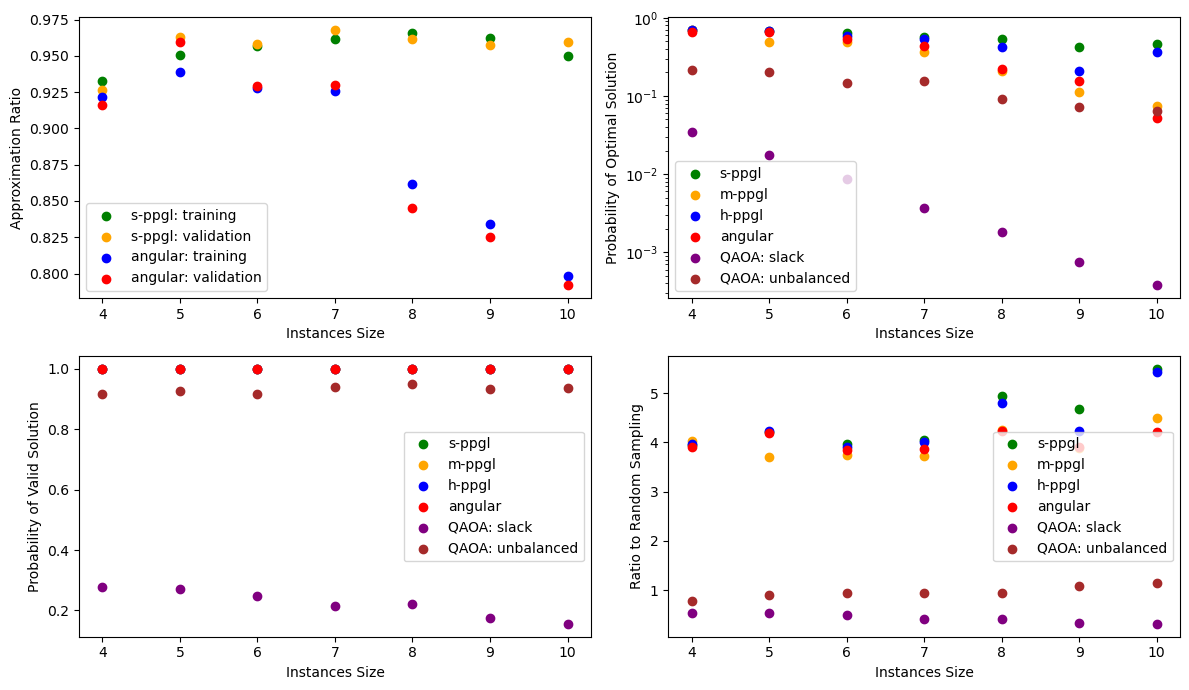

In [8]:
import matplotlib.pyplot as plt

# Assuming you have defined `problem_sizes` and `dataset_size` somewhere in your code

fig, ax = plt.subplots(2,2,tight_layout = True, figsize = (12,7))

# Plot the data as a vertical scatter plot
for i,size in enumerate(problem_sizes):
    ax[0,0].scatter(size , np.mean(qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["test"]),color='green', label="s-ppgl: training" if i == 0 else None)
    ax[0,0].scatter(size, np.mean(qrl_results["approximation_ratios"][f"{size}"]["=s-ppgl"]["validation"]),color='orange', label="s-ppgl: validation" if i == 0 else None)
    ax[0,0].scatter(size, np.mean(qrl_results["approximation_ratios"][f"{size}"]["=angular"]["test"]),color='blue', label="angular: training" if i == 0 else None)
    ax[0,0].scatter(size , np.mean(qrl_results["approximation_ratios"][f"{size}"]["=angular"]["validation"]),color='red', label="angular: validation" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,0].set_xticks(custom_ticks)

ax[0,0].set_xlabel("Instances Size")
ax[0,0].set_ylabel("Approximation Ratio")

# Manually create legend
ax[0,0].legend(["s-ppgl: training", "s-ppgl: validation","angular: training","angular: validation"])


for i,size in enumerate(problem_sizes):
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qrl_results["optimal_probability"][f"{size}"]["=angular"]["validation"]),color='red', label="angular" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qaoa_results_final["slack"][size]["optimal_probability"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[0,1].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["optimal_probability"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[0,1].set_xticks(custom_ticks)

ax[0,1].set_xlabel("Instances Size")
ax[0,1].set_ylabel("Probability of Optimal Solution")
ax[0,1].set_yscale("log")

# Manually create legend
ax[0,1].legend(["s-ppgl", "m-ppgl","h-ppgl","angular", "QAOA: slack", "QAOA: unbalanced"])

for i,size in enumerate(problem_sizes):
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qrl_results["valid_probability"][f"{size}"]["=angular"]["validation"]),color='red', label="angular" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qaoa_results_final["slack"][size]["valid_probability"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[1,0].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["valid_probability"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,0].set_xticks(custom_ticks)

ax[1,0].set_xlabel("Instances Size")
ax[1,0].set_ylabel("Probability of Valid Solution")

# Manually create legend
ax[1,0].legend(["s-ppgl", "m-ppgl","h-ppgl","angular", "QAOA: slack", "QAOA: unbalanced"])


for i,size in enumerate(problem_sizes):
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=s-ppgl"]["validation"]),color='green', label="s-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=m-ppgl"]["validation"]),color='orange', label="m-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=h-ppgl"]["validation"]),color='blue', label="h-ppgl" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qrl_results["better_than_random"][f"{size}"]["=angular"]["validation"]),color='red', label="angular" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qaoa_results_final["slack"][size]["better_than_random"]),color='purple', label="QAOA: slack" if i == 0 else None)
    ax[1,1].scatter(size, np.mean(qaoa_results_final["unbalanced"][size]["better_than_random"]),color='brown', label="QAOA: unbalanced" if i == 0 else None)

# Set custom x-axis ticks
custom_ticks = [size for size in problem_sizes]  # Assuming problem_sizes is a list of x-axis tick values
ax[1,1].set_xticks(custom_ticks)

ax[1,1].set_xlabel("Instances Size")
ax[1,1].set_ylabel("Ratio to Random Sampling")

# Manually create legend
ax[1,1].legend(["s-ppgl", "m-ppgl","h-ppgl","angular", "QAOA: slack", "QAOA: unbalanced"])

#Display the plot
plt.savefig("final_qaoaqrl_comparison_mean.pdf")
plt.show()